come v4 ma aggiungendo nuovi nodi e tool

In [30]:
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_core.output_parsers import JsonOutputParser
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from typing_extensions import TypedDict
from typing import List
from langchain.schema import Document
from langgraph.graph import END, StateGraph
from pprint import pprint

In [2]:
import sys 
sys.path.append(r'C:\Users\ELAFACRB1\Codice\GitHub\rio-utils-app\src')
sys.path.append(r'..')
from tools.retrieval_eventi import get_relevant_document_tool 
from tools.tavily import web_search_tool 
from tools.utils import get_today_date_tool, get_summarized_text_tool
from tools.aws import ec2_shutdown_tools, ec2_turnon_tools
from utils.text_processing import TextSplitter
from utils.embedding import EmbeddingFunction
from utils.database_managers import QDrantDBManager
import os

c:\Users\ELAFACRB1\Codice\GitHub\langgraph-rag-chatbot\venv\chatbot\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 4763.01it/s]


In [3]:
### State
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

# Graph
workflow = StateGraph(GraphState)

In [4]:
embedding = EmbeddingFunction('fast-bgeEmbedding').embedder

Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


In [5]:
embedding = EmbeddingFunction('fast-bgeEmbedding').embedder
text_splitter = TextSplitter(
    chunk_size=2000, 
    chunk_overlap=20
)

QDRANT_URL=os.getenv('QDRANT_URL')
COLLECTION_NAME="web-places"

qdrantClient = QDrantDBManager(
    url=QDRANT_URL,
    port=6333,
    collection_name=COLLECTION_NAME,
    vector_size=768,
    embedding=embedding,
    record_manager_url="sqlite:///record_manager_cache.sql"
)
retriever=qdrantClient.vector_store.as_retriever()


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 5526.09it/s]


Collection web-places already exists!


c:\Users\ELAFACRB1\Codice\GitHub\langgraph-rag-chatbot\venv\chatbot\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 0.3.0. An updated version of the class exists in the langchain-qdrant package and should be used instead. To use it run `pip install -U langchain-qdrant` and import as `from langchain_qdrant import Qdrant`.
  warn_deprecated(


In [6]:
tools = [get_relevant_document_tool, get_today_date_tool, web_search_tool, ec2_shutdown_tools, ec2_turnon_tools, get_summarized_text_tool]

In [7]:
llm = ChatGroq(
    temperature=0, 
    model_name="Llama3-8b-8192"
    )

In [8]:
topics = ["eventi, locali, ristoranti"]

In [9]:
# question = "accendi EC2"

In [10]:
### Router

# Topics should be dynamically fetched and updated whenever a new topic gets put in the vector store

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> Sei un esperto nell'inoltrare una domanda 
        utente a un archivio vettoriale o a una ricerca web.  Usa l'archivio vettoriale per le domande sui seguenti argomenti: {topics}. Non è necessario essere rigidi con le parole chiave.
        Usa i tool relativi ad AWS per le richieste relative alle operazioni su strumenti cloud come accendere/spegnere VM EC2, lanciare lambda, accendere/spegnere database, etc. 
        Non usare tool AWS per domande teoriche relative agli strumenti Cloud (per le quali è necessario usare una ricerca web). 
        Altrimenti, per tutto il resto, utilizza la ricerca web.  
        Fornisci una scelta binaria 'web_search', 'aws_tool' o 'vectorstore' in base alla domanda. 
        Restituisci un JSON con una singola chiave 'datasource' e senza preamboli o spiegazioni.
        Domanda da inoltrare: Domande da indirizzare: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["topics", "question"],
)
partial_prompt = prompt.partial(topics=', '.join(topics))
question_router = partial_prompt | llm | JsonOutputParser()

#test
# print(question_router.invoke({"question": question}))

In [11]:
question_router

PromptTemplate(input_variables=['question'], partial_variables={'topics': 'eventi, locali, ristoranti'}, template="<|begin_of_text|><|start_header_id|>system<|end_header_id|> Sei un esperto nell'inoltrare una domanda \n        utente a un archivio vettoriale o a una ricerca web.  Usa l'archivio vettoriale per le domande sui seguenti argomenti: {topics}. Non è necessario essere rigidi con le parole chiave.\n        Usa i tool relativi ad AWS per le richieste relative alle operazioni su strumenti cloud come accendere/spegnere VM EC2, lanciare lambda, accendere/spegnere database, etc. \n        Non usare tool AWS per domande teoriche relative agli strumenti Cloud (per le quali è necessario usare una ricerca web). \n        Altrimenti, per tutto il resto, utilizza la ricerca web.  \n        Fornisci una scelta binaria 'web_search', 'aws_tool' o 'vectorstore' in base alla domanda. \n        Restituisci un JSON con una singola chiave 'datasource' e senza preamboli o spiegazioni.\n        Dom

In [12]:
### Generate
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> Sei un assistente per compiti di domande e risposte.
    Usa i seguenti pezzi di contesto recuperati per rispondere alla domanda. Se non conosci la risposta, dì semplicemente che non la conosci.
    Usa un massimo di tre frasi e mantieni la risposta concisa. 
    Fornisci la risposta con una lista nella quale ogni elemento rispetta questa struttura:
    1. Nome luogo/evento
    2. Descrizione
    3. Indirizzo se presente
    4. Sito web/email/numero di telefono se presente
    Restituisci la risposta in markdown.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Domanda: {question}
    Contesto: {context}
    Risposta: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Test
# docs = retriever.invoke(question)
# generation = rag_chain.invoke({"context": docs, "question": question})

# from IPython.display import display, Markdown, Latex
# display(Markdown(generation))

In [13]:
### Retrieval Grader

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> Sei un valutatore che valuta la rilevanza 
    di un documento recuperato rispetto a una domanda dell'utente. 
    Se il documento contiene parole chiave relative alla domanda dell'utente, valutalo come rilevante. 
    Non deve essere un test rigoroso. L'obiettivo è filtrare i recuperi errati. 
    Dai un punteggio binario 'sì' o 'no' per indicare se il documento è rilevante per la domanda. 
    Fornisci il punteggio binario come un JSON con una singola chiave 'score' e senza preamboli o spiegazioni.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()

# #test
# docs = retriever.invoke(question)
# doc_txt = docs[0].page_content
# print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

In [14]:
### Hallucination Grader

# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> Sei un valutatore che valuta se 
    una risposta è basata su / supportata da un insieme di fatti. Dai un punteggio binario 'sì' o 'no' per indicare 
    se la risposta è basata su / supportata da un insieme di fatti. Fornisci il punteggio binario come un JSON con una 
    singola chiave 'score' e senza preamboli o spiegazioni. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Ecco i fatti:
    \n ------- \n
    {documents}
    \n ------- \n
    Ecco la risposta: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)
hallucination_grader = prompt | llm | JsonOutputParser()

#test
# hallucination_grader.invoke({"documents": docs, "generation": generation})

In [15]:
### Answer Grader

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> Sei un valutatore che valuta se 
    una risposta è utile per risolvere una domanda. Dai un punteggio binario 'sì' o 'no' per indicare se la risposta è 
    utile per risolvere una domanda. Fornisci il punteggio binario come un JSON con una singola chiave 'score' e senza preamboli o spiegazioni.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation}
    \n ------- \n
    Di seguito la domanda: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)
answer_grader = prompt | llm | JsonOutputParser()

#test
# answer_grader.invoke({"question": question, "generation": generation})

Nodes

In [16]:
def retrieve(state):
    """
    Retrieve documents from vectorstore
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "si":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Si"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

def web_search(state):
    """
    Web search based based on the question
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Appended web results to documents
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}



In [17]:
# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae

Create nodes from agent

In [18]:
from utils.langgraph_functions import create_agent, tool_node, agent_node, create_node_from_agent

In [19]:
tool_executor = ToolExecutor(tools)

In [29]:
# Psychologist agent and node
aws_agent = create_agent(
    llm,
    [ec2_shutdown_tools, ec2_turnon_tools],
    system_message="Un tecnico esperto che sa come usare il cloud AWS per effettuare operazioni su macchine virtuali EC2, lambda, database, etc..",
)


#test
question=["spegni ec2"]
aws_agent.invoke(question)

TypeError: Completions.create() got an unexpected keyword argument 'functions'

In [21]:
aws_node=create_node_from_agent(aws_agent, "technician")

In [22]:
workflow.add_node("technician", aws_node)

Edges

In [23]:
### Conditional edge

def route_question(state):
    """
    Route question to web search or RAG.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]
    if web_search == "si":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Conditional edge

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Decision for next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]
    # Check hallucination
    if grade == "si":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "si":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [24]:
# Build graph
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("technician", END)

workflow.set_conditional_entry_point( #setta il router iniziale
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
        "aws_tool": "technician"
    },
)

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)


workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)


In [25]:
app = workflow.compile()

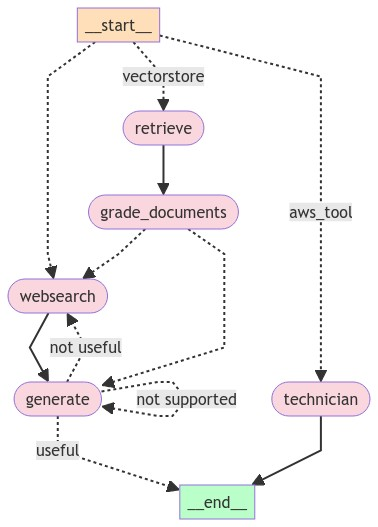

In [26]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
inputs = {"question": "spegni la VM EC2"}
try:
    for output in app.stream(inputs):
        for key, value in output.items():
            pprint(f"Finished running: {key}:")
    pprint(value["generation"])
except Exception as exc:
    print(exc)
    pprint("Non sono riuscito a comprendere la tua richiesta scusa :(")

---ROUTE QUESTION---
spegni la VM EC2
{'datasource': 'aws_tool'}
aws_tool
None
'Non sono riuscito a comprendere la tua richiesta scusa :('
